In [2]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
from torchvision import transforms
from torch.nn import functional as F
from torch import nn
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# torch.cuda.set_device(1)

### Data preprocess

In [4]:
training_prefix_path = './animal-10/train/'
testing_prefix_path = './animal-10/val/'

training_image_folder_list = glob.glob(training_prefix_path + '*')
testing_image_folder_list = glob.glob(testing_prefix_path + '*')
print(training_image_folder_list)

['./animal-10/train/spider', './animal-10/train/squirrel', './animal-10/train/cat', './animal-10/train/cow', './animal-10/train/horse', './animal-10/train/sheep', './animal-10/train/butterfly', './animal-10/train/chicken', './animal-10/train/elephant', './animal-10/train/dog']


In [5]:
label_name_list = [_.split('/')[-1] for _ in training_image_folder_list]
print(label_name_list)

['spider', 'squirrel', 'cat', 'cow', 'horse', 'sheep', 'butterfly', 'chicken', 'elephant', 'dog']


In [6]:
preprocess = transforms.Compose([
             transforms.Resize((256, 256)),
             transforms.ToTensor(), # transform to (0, 1)
             transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)), # transform to (-1, 1)
             ])

In [7]:
# load training dataset
if not (os.path.isfile('./images_train_X.npy') and os.path.isfile('./images_train_y.npy')): 
    images = []
    labels = []
    label_count = 0

    for training_image_floder in training_image_folder_list:
        print('load images from: ', training_image_floder )
        imgs_path_list = glob.glob(training_image_floder + '/*')

        for idx, img_path in enumerate(imgs_path_list):
            img = preprocess(Image.open(img_path).convert('RGB'))
            img = img.numpy()

            images.append(img)

        labels.extend([label_count] * len(imgs_path_list))
        label_count += 1

    images = np.array(images)
    labels = np.array(labels)

    np.save('./images_train_X.npy', images)
    np.save('./images_train_y.npy', labels)
    print(images.shape, labels.shape)
else:
    images = np.load('./images_train_X.npy')
    labels = np.load('./images_train_y.npy')

    print(images.shape, labels.shape)
    
train_X = torch.from_numpy(images)
train_y = torch.from_numpy(labels)

(10000, 3, 256, 256) (10000,)


In [8]:
if not (os.path.isfile('./images_test_X.npy') and os.path.isfile('./images_test_y.npy')): 
    images = []
    labels = []
    label_count = 0

    for testing_image_floder in testing_image_folder_list:
        print('load images from: ', testing_image_floder )
        imgs_path_list = glob.glob(testing_image_floder + '/*')

        for idx, img_path in enumerate(imgs_path_list):
            img = preprocess(Image.open(img_path).convert('RGB'))
            img = img.numpy()

            images.append(img)

        labels.extend([label_count] * len(imgs_path_list))
        label_count += 1

    images = np.array(images)
    labels = np.array(labels)

    np.save('./images_test_X.npy', images)
    np.save('./images_test_y.npy', labels)
    print(images.shape, labels.shape)
else:
    images = np.load('./images_test_X.npy')
    labels = np.load('./images_test_y.npy')

    print(images.shape, labels.shape)
    
test_X = torch.from_numpy(images)
test_y = torch.from_numpy(labels)

(4000, 3, 256, 256) (4000,)


In [9]:
train_dataset = Data.TensorDataset(train_X, train_y)
test_dataset = Data.TensorDataset(test_X, test_y)

In [10]:
train_loader = Data.DataLoader(
    dataset = train_dataset,      # torch TensorDataset format
    batch_size = 128,      # mini batch size
    shuffle = True,               # 要不要打乱数据 (打乱比较好)
    num_workers=4,              # 多线程来读数据
)

In [11]:
test_loader = Data.DataLoader(
    dataset = test_dataset,      # torch TensorDataset format
    batch_size = 64,      # mini batch size
    shuffle = False,
    num_workers=4,              # 多线程来读数据
)

### ResNet

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride, 1, bias=False), # bias=False是因為bias再BN中已經有了，如果stride=2則shape會變成一半
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False), # shape前後仍然一漾
            nn.BatchNorm2d(out_channel),
        )
        
        self.right = shortcut #根據情況是否做出增維或是縮小shape
        
    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out = out + residual
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False), #為了使shape變一半，stride必須是2，在固定kernel=7下由公式推得padding=3
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1) , #為了使shape變一半，stride必須是2，在固定kernel=3下由公式推得padding=1
        )
        
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2) # 對照架構圖，第二段後每次都會將shape再度縮小一半
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channel, out_channel, block_num, stride=1):
        
        # shortcut的部份必須和該block最後一層維度相同，所以這裡做1d conv增加維度
        # 並且根據有沒有縮小shape(stride=2)做相同的動作
        shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel,  1, stride, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        
        layers = []
        # 第一次的ResidualBlock可能會縮小shape(根據stride)，所以要獨立出來做
        layers.append(ResidualBlock(in_channel, out_channel, stride, shortcut)) 
        
        #注意這邊都是第二次以後的ResidualBlock，所以不會有維度或大小不同的問題，參數跟shortcut都不用做
        for i in range(1, block_num):
            layers.append(ResidualBlock(out_channel, out_channel))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # print('origin:', x.shape) # (batch, channel, w, h)
        
        x = self.pre_layer(x)
        # print('pre_layer:', x.shape) # (batch, channel, w, h) -> # (batch, 64, w/4, h/4)
        
        x = self.layer1(x)
        # print('layer1:', x.shape) # (batch, 64, w/4, h/4) -> (batch, 64, w/4, h/4)
        
        x = self.layer2(x)
        # print('layer2:', x.shape) # (batch, 64, w/4, h/4) -> (batch, 128, w/8, h/8)
        
        x = self.layer3(x)
        # print('layer3:', x.shape) # (batch, 128, w/8, h/8) -> (batch, 256, w/16, h/16)
        
        x = self.layer4(x)
        # print('layer4:', x.shape) # (batch, 256, w/16, h/16) -> (batch, 512, w/32, h/32)
        
        x = F.avg_pool2d(x, x.shape[3]) 
        # print('avg_pool:', x.shape) # (batch, 512, w/32, h/32) -> (batch, 512, 1, 1)
        
        x = x.view(x.size(0), -1) # (batch, 512, 1, 1) -> (batch, 512 * 1 * 1)
        # print('flatten:', x.shape)
        
        out = self.fc(x)
        return out

In [13]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Sequential( # input shape:(1, 256, 256)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (32, 128, 128)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,  out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (64, 64, 64)
        )
        self.out = nn.Linear(in_features=64 * 64 * 64, out_features=10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten
        x = x.view(x.size()[0], -1) # (batch size, 28*28)
        output = self.out(x)
        return output

In [14]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Sequential( # input shape:(1, 256, 256)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (32, 128, 128)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # output shape: (64, 64, 64)
        )
        self.out = nn.Linear(in_features=64 * 64 * 64, out_features=10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten
        x = x.view(x.size()[0], -1) # (batch size, 28*28)
        output = self.out(x)
        return output

In [15]:
class module():
    def __init__(self, net, train_loader, test_loader, EPOCH=20, LR=0.0001):
        self.net = net
        self.optimizer = torch.optim.Adam(net.parameters(), lr = LR)
        self.criterion = nn.CrossEntropyLoss()
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.EPOCH_ = EPOCH
        self.LR_ = LR

        self.net = self.net.to(device)
        if device == 'cuda':
            self.net = torch.nn.DataParallel(self.net)
            torch.backends.cudnn.benchmark = True

    def start(self):

        history_loss = []
        history_train_acc = []
        history_test_acc = []
        for epoch in range(self.EPOCH_):
            print('Epoch:', epoch)
            train_loss, train_acc = self.train()
            test_loss, test_acc = self.test()

            history_loss.append(train_loss)
            history_train_acc.append(train_acc)
            history_test_acc.append(test_acc)
        return history_loss, history_train_acc, history_test_acc

    def train(self):
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        for step, (batch_X, batch_y) in enumerate(self.train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            self.optimizer.zero_grad()
            outputs = self.net(batch_X)
            loss = self.criterion(outputs, batch_y)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()        

        print('【Training】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( train_loss, 100.*(correct/total), correct, total ))
        return train_loss, (correct/total)

    def test(self):
        self.net.eval()

        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad(): 
            for step, (batch_X, batch_y) in enumerate(self.test_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = self.net(batch_X)
                loss = self.criterion(outputs, batch_y)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item()   

        print('【Testing】Loss: %.3f | Acc: %.3f%% (%d/%d)' % ( test_loss, 100.*(correct/total), correct, total ))
        return test_loss, (correct/total)

#### CNN_1結果

In [16]:
cnn1_module = module(CNN_1(), train_loader, test_loader)
history_loss, history_train_acc, history_test_acc = cnn1_module.start()

Epoch: 0
【Training】Loss: 165.782 | Acc: 24.850% (2485/10000)
【Testing】Loss: 118.886 | Acc: 34.250% (1370/4000)
Epoch: 1
【Training】Loss: 136.194 | Acc: 41.070% (4107/10000)
【Testing】Loss: 108.228 | Acc: 40.000% (1600/4000)
Epoch: 2
【Training】Loss: 120.637 | Acc: 49.170% (4917/10000)
【Testing】Loss: 100.465 | Acc: 45.925% (1837/4000)
Epoch: 3
【Training】Loss: 106.416 | Acc: 55.990% (5599/10000)
【Testing】Loss: 102.730 | Acc: 45.875% (1835/4000)
Epoch: 4
【Training】Loss: 93.867 | Acc: 61.990% (6199/10000)
【Testing】Loss: 96.264 | Acc: 48.425% (1937/4000)
Epoch: 5
【Training】Loss: 79.035 | Acc: 69.140% (6914/10000)
【Testing】Loss: 99.359 | Acc: 48.400% (1936/4000)
Epoch: 6
【Training】Loss: 67.112 | Acc: 73.490% (7349/10000)
【Testing】Loss: 98.083 | Acc: 49.950% (1998/4000)
Epoch: 7
【Training】Loss: 54.731 | Acc: 79.370% (7937/10000)
【Testing】Loss: 101.934 | Acc: 49.125% (1965/4000)
Epoch: 8
【Training】Loss: 43.121 | Acc: 85.040% (8504/10000)
【Testing】Loss: 111.161 | Acc: 47.825% (1913/4000)
Epoch: 9


In [17]:
print('total number of parameters:', sum(p.numel() for p in cnn1_module.net.parameters()))

total number of parameters: 2726602


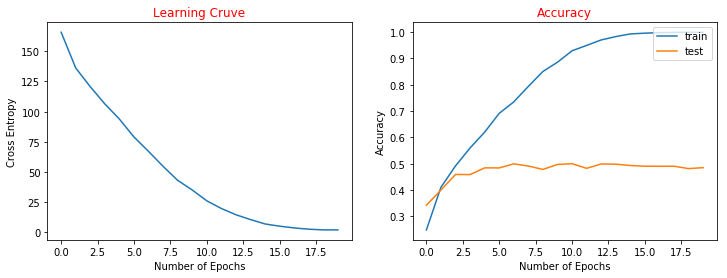

In [18]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_loss)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
plt.legend(loc=1)

#### CNN_2結果

In [19]:
cnn2_module = module(CNN_2(), train_loader, test_loader)
history_loss, history_train_acc, history_test_acc = cnn2_module.start()

Epoch: 0
【Training】Loss: 169.882 | Acc: 24.440% (2444/10000)
【Testing】Loss: 119.843 | Acc: 35.825% (1433/4000)
Epoch: 1
【Training】Loss: 142.328 | Acc: 38.540% (3854/10000)
【Testing】Loss: 109.971 | Acc: 40.825% (1633/4000)
Epoch: 2
【Training】Loss: 127.663 | Acc: 45.990% (4599/10000)
【Testing】Loss: 105.243 | Acc: 43.350% (1734/4000)
Epoch: 3
【Training】Loss: 118.481 | Acc: 49.940% (4994/10000)
【Testing】Loss: 101.776 | Acc: 45.300% (1812/4000)
Epoch: 4
【Training】Loss: 109.931 | Acc: 54.130% (5413/10000)
【Testing】Loss: 99.584 | Acc: 46.650% (1866/4000)
Epoch: 5
【Training】Loss: 103.667 | Acc: 57.080% (5708/10000)
【Testing】Loss: 98.371 | Acc: 47.150% (1886/4000)
Epoch: 6
【Training】Loss: 97.186 | Acc: 60.850% (6085/10000)
【Testing】Loss: 99.807 | Acc: 46.825% (1873/4000)
Epoch: 7
【Training】Loss: 89.536 | Acc: 64.510% (6451/10000)
【Testing】Loss: 96.947 | Acc: 47.275% (1891/4000)
Epoch: 8
【Training】Loss: 84.041 | Acc: 66.580% (6658/10000)
【Testing】Loss: 96.133 | Acc: 47.000% (1880/4000)
Epoch: 9


In [20]:
print('total number of parameters:', sum(p.numel() for p in cnn2_module.net.parameters()))

total number of parameters: 2640842


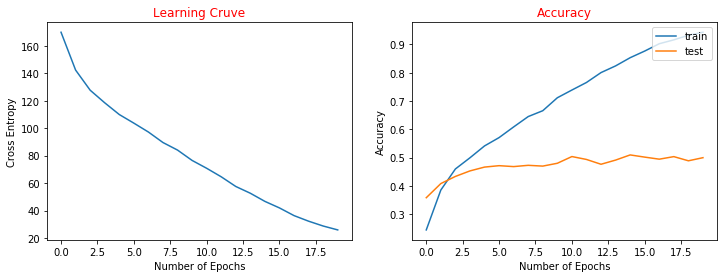

In [21]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_loss)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
plt.legend(loc=1)

#### Resnet結果

In [22]:
resnet_module = module(ResNet(), train_loader, test_loader)
history_loss, history_train_acc, history_test_acc = resnet_module.start()

Epoch: 0
【Training】Loss: 149.851 | Acc: 31.870% (3187/10000)
【Testing】Loss: 116.901 | Acc: 33.925% (1357/4000)
Epoch: 1
【Testing】Loss: 89.541 | Acc: 54.125% (2165/4000)
Epoch: 5
【Training】Loss: 48.114 | Acc: 79.690% (7969/10000)
【Testing】Loss: 118.989 | Acc: 46.350% (1854/4000)
Epoch: 6
【Training】Loss: 32.614 | Acc: 86.900% (8690/10000)
【Testing】Loss: 138.941 | Acc: 46.075% (1843/4000)
Epoch: 7
【Training】Loss: 22.518 | Acc: 91.410% (9141/10000)
【Testing】Loss: 92.205 | Acc: 57.700% (2308/4000)
Epoch: 8
【Training】Loss: 18.506 | Acc: 92.800% (9280/10000)
【Testing】Loss: 110.495 | Acc: 52.025% (2081/4000)
Epoch: 9
【Training】Loss: 11.795 | Acc: 95.690% (9569/10000)
【Testing】Loss: 130.697 | Acc: 50.325% (2013/4000)
Epoch: 10
【Training】Loss: 7.606 | Acc: 97.410% (9741/10000)
【Testing】Loss: 95.018 | Acc: 60.200% (2408/4000)
Epoch: 11
【Training】Loss: 6.762 | Acc: 97.870% (9787/10000)
【Testing】Loss: 103.772 | Acc: 57.650% (2306/4000)
Epoch: 12
【Training】Loss: 4.336 | Acc: 98.740% (9874/10000)
【Te

In [23]:
print('total number of parameters:', sum(p.numel() for p in resnet_module.net.parameters()))

total number of parameters: 21294026


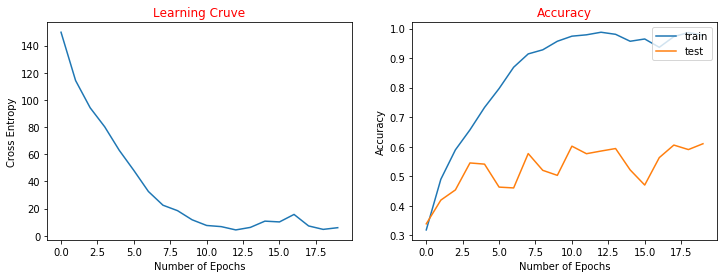

In [24]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_loss)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_test_acc, label = 'test')
plt.legend(loc=1)

In [25]:
def plot_imgs():
    fig = plt.gcf()
    fig.set_size_inches((15,20))

    with torch.no_grad(): 
        for i in range(10):
            idx = i * 400 + 1
            temp = torch.from_numpy(np.expand_dims(test_X[idx], axis=0)).to(device)
            outputs = resnet_module.net(temp)
            _, predicted = outputs.max(1)

            ax = plt.subplot(5, 5, i+1)
            ax.imshow(np.transpose(test_X[idx].numpy(), (1, 2, 0)))
            title = 'label:' + label_name_list[test_y[idx]] + ', predict:' + label_name_list[predicted]
            if(test_y[idx].item() == predicted.item()):
                ax.set_title(title, fontsize=10)
            else:
                ax.set_title(title, fontsize=10, color='red')

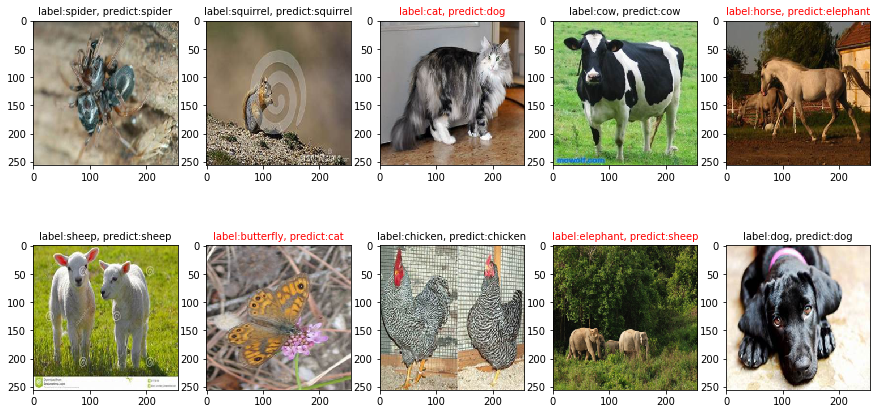

In [26]:
plot_imgs()

In [66]:
print('%22s'%'Accuracy of classes')
print('--------------------------')
with torch.no_grad(): 
    for label_idx in range(10):
        temp_input = test_X[400*label_idx : 400*(label_idx+1)]
        temp_label = test_y[400*label_idx : 400*(label_idx+1)]
#         temp_input = temp_input.to(device)
#         temp_label = temp_label.to(device)
        outputs = resnet_module.net(temp_input)

        _, predicted = outputs.max(1)
        # print(predicted)
        correct = predicted.eq(temp_label.cuda()).sum().item()  
        print('%9s'%label_name_list[label_idx] + 
              ' : %.2f'% (correct/len(temp_label)) + '('+ str(correct) + '/'+ str(len(temp_label)) + ')')


   Accuracy of classes
--------------------------
   spider : 0.62(247/400)
 squirrel : 0.49(198/400)
      cat : 0.60(239/400)
      cow : 0.54(217/400)
    horse : 0.49(195/400)
    sheep : 0.76(304/400)
butterfly : 0.76(304/400)
  chicken : 0.78(310/400)
 elephant : 0.52(209/400)
      dog : 0.55(218/400)
